In [1]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot

PyPlot

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

As shown [here](https://doi.org/10.1103/PhysRevX.8.011038), a trapped ion system can be used to approximate the dynamics corresponding to the Hamiltonian:

---
${\Large
\hat{H} = \frac{J}{2} \hat{\sigma}_x^{(1)} \otimes  \hat{\sigma}_x^{(2)} + \frac{\Delta}{2}  \hat{\sigma}_z^{(2)} + \frac{\kappa}{2}  \hat{\sigma}_z^{(2)} \otimes (\hat{a} + \hat{a}^{\dagger}) + \nu_{eff} \hat{a}^{\dagger}\hat{a}
}
$

---

which can be used to model a process known as *vibrationally assisted energy transport* or VAET. 

For an initial state $|\uparrow \downarrow\rangle$, the effect of the first term in this Hamiltonian is to cause oscillations between the populations of the states $|\uparrow \downarrow\rangle \leftrightarrow |\downarrow \uparrow\rangle$ at a rate $J/2$. If $\Delta$, which represents an energy barrier, becomes comparable in magnitude to $J$, then these oscillations will be suppressed. But if also $\nu_{eff} \approx \Delta$ then we can still achieve population transfer between the two spins by storing or borrowing energy from the coupled vibrational mode.


* The first spin-spin term in the Hamiltonian can be engineered with two laser tones, using a Molmer-Sorensen type interaction, as in the ramped_molmer_sorensen example, but now in the off-resonant limit: $\eta_i \Omega \ll |\nu_i-\delta|$, which gives: 


---
${\Large
\hat{H}_{MS} = \frac{(\eta_i\Omega)^2}{2(\nu_i-\delta)} \hat{\sigma}_x^{(1)} \otimes  \hat{\sigma}_x^{(2)}
}
$

---

* The second term:


---
${\Large
\hat{H}_{barrier} = \frac{\Delta}{2}  \hat{\sigma}_z^{(2)}
}
$

---

&nbsp; &nbsp; &nbsp; &nbsp; can be engineered via an AC stark shift, B-field gradient or directly in IonSim with the `stark_shift` field of an `<:Ion`.

* Finally, the last terms can be engineered using two laser tones, similar to the Molmer Sorensen, but interacting with only a single ion and with the detunings from the carrier transition equal to plus/minus half of the frequency of the coupled vibrational mode [[ref]](https://doi.org/10.1103/PhysRevA.77.050303). This gives:


---
${\Large
\hat{H}_{S-B} = \frac{\eta_i \Omega^2}{2\nu_i}  \hat{\sigma}_z^{(2)} \otimes (\hat{a} + \hat{a}^{\dagger}) + \nu_{eff} \hat{a}^{\dagger}\hat{a}
}$

---

Let's see how to simulate this in IonSim

In [3]:
# Construct the system
C = Ca40(["S-1/2", "D-1/2"])
L1 = Laser(); L1.pointing = [(1, 1.0), (2, 1.0)]
L2 = Laser(); L2.pointing = [(1, 1.0), (2, 1.0)]
chain = LinearChain(ions=[C, C], com_frequencies=(x=3e6,y=3e6,z=1e6), vibrational_modes=(x=[1], z=[1]))
T = Trap(configuration=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[L1, L2]);

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /Users/josephbroz/Desktop/IonSim/IonSim.jl/src/ion_configurations.jl:162



${\Large \hat{H} = \hat{H}_{MS} }$


In [4]:
# Set the laser parameters
axial_mode = T.configuration.vibrational_modes.z[1]
radial_mode = T.configuration.vibrational_modes.x[1]

Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
ϵ = 40e3

L1.Δ = Δf + axial_mode.ν + ϵ 
L1.k = ẑ
L1.ϵ = x̂

L2.Δ = Δf - axial_mode.ν - ϵ
L2.k = ẑ
L2.ϵ = x̂

η = abs(get_η(axial_mode, L1, C))
Ω = √(1e3 * ϵ) / η  # This will give a 1kHz MS strength, since coupling goes like (ηΩ)^2/ϵ

Efield_from_rabi_frequency!(Ω, T, 1, 1, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω, T, 2, 1, ("S-1/2", "D-1/2"));

In [5]:
axial_mode.N = 5
radial_mode.N = 5;

In [6]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1e6);

In [9]:
@time tout, sol_res = timeevolution.schroedinger_dynamic(0:2:3000, 
    ionstate(T, "D-1/2", "S-1/2") ⊗ fockstate(axial_mode, 0) ⊗ fockstate(radial_mode, 0), h);

  0.608855 seconds (8.95 M allocations: 276.606 MiB, 12.07% gc time)


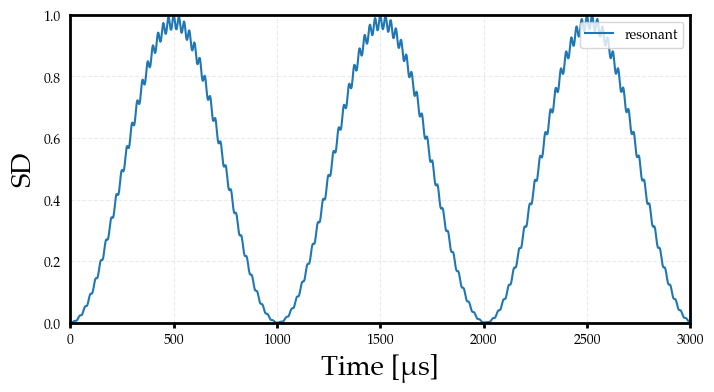

In [10]:
SD_res = expect(ionprojector(T, "S-1/2", "D-1/2"), sol_res)
step = 1
plt.plot(tout[1:step:end], SD_res[1:step:end], label="resonant")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("SD")
plt.xlabel("Time [μs]");


${\Large \hat{H} = \hat{H}_{MS} + \hat{H}_{barrier}}$


In [11]:
# We'll add the barrier term by giving a nonzero value to the trap's B-field gradient:
set_gradient!(T, (1, 2), ("S-1/2", "D-1/2"), √5.25 * 1e3); 
# ΩMS = 1 kHz, so setting Δ = √5.25 kHz gives Ω' = √(ΩMS^2 + Δ^2) = 2.5 kHz

In [12]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1e6);

In [13]:
@time tout, sol_det = timeevolution.schroedinger_dynamic(0:2:3000, 
    ionstate(T, "D-1/2", "S-1/2") ⊗ fockstate(axial_mode, 0) ⊗ fockstate(radial_mode, 0), h);

  0.564600 seconds (8.67 M allocations: 268.076 MiB, 8.88% gc time)


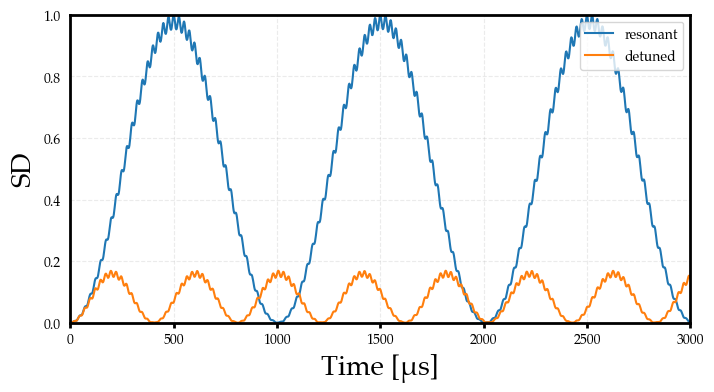

In [15]:
SD_det = expect(ionprojector(T, "S-1/2", "D-1/2"), sol_det)
step = 1
plt.plot(tout[1:step:end], SD_res[1:step:end], label="resonant")
plt.plot(tout[1:step:end], SD_det[1:step:end], label="detuned")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("SD")
plt.xlabel("Time [μs]");


${\Large\hat{H} = \hat{H}_{MS} + \hat{H}_{barrier} + \hat{H}_{S-B} }$


In [16]:
# setup two additional lasers for the S-B Hamiltonian
L3 = Laser(); L3.pointing = [(2, 1.0)]
L4 = Laser(); L4.pointing = [(2, 1.0)];

In [17]:
T.lasers = [L1, L2, L3, L4];

In [18]:
# Set the laser parameters
axial_mode = T.configuration.vibrational_modes.z[1]
radial_mode = T.configuration.vibrational_modes.x[1]

Δf = transition_frequency(T, 2, ("S-1/2", "D-1/2"))
νeff = √5.25 * 1e3

L3.Δ = Δf + radial_mode.ν / 2 + νeff  # We set the effective vibrational frequency by detuning the 2-photon transition off resonance
L3.k = x̂
L3.ϵ = ẑ

L4.Δ = Δf - radial_mode.ν / 2
L4.k = x̂
L4.ϵ = ẑ

η = abs(get_η(radial_mode, L3, C))
Ω = √((0.5e3 * radial_mode.ν) / η)  # Set κ = 0.5 kHz, since κ = ηΩ^2/ν

Efield_from_rabi_frequency!(Ω, T, 3, 2, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω, T, 4, 2, ("S-1/2", "D-1/2"));

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /Users/josephbroz/Desktop/IonSim/IonSim.jl/src/lasers.jl:75
┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /Users/josephbroz/Desktop/IonSim/IonSim.jl/src/lasers.jl:75


In [19]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1.51e6);

In [ ]:
@time tout, sol_vaet = timeevolution.schroedinger_dynamic(0:2:3000, 
    ionstate(T, "D-1/2", "S-1/2") ⊗ fockstate(axial_mode, 0) ⊗ fockstate(radial_mode, 0), h);

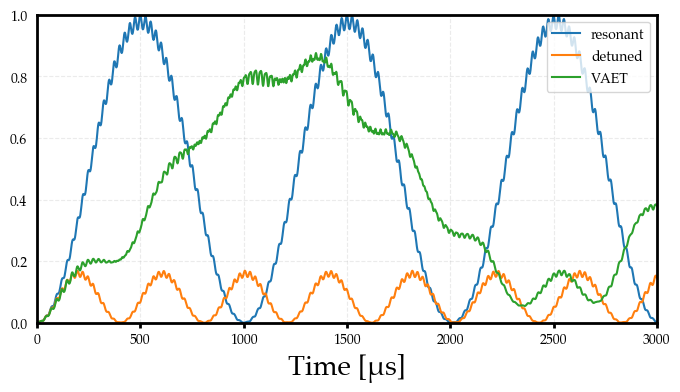

In [22]:
SD_vaet = expect(ionprojector(T, "S-1/2", "D-1/2"), sol_vaet)
step = 1
plt.plot(tout[1:step:end], SD_res[1:step:end], label="resonant")
plt.plot(tout[1:step:end], SD_det[1:step:end], label="detuned")
plt.plot(tout[1:step:end], SD_vaet[1:step:end], label="VAET")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");